In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import ks_2samp
from pipeline_transformers import LogTransformer, FeatureCreation, FeatureRemoval
from evaluation_functions import evaluate_model_with_train

shap.initjs()

C:\Users\nbeha\AppData\Local\Temp\ipykernel_16832\266234479.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def calculate_ks(df, target, preds1, preds0, identifier=''):

    df0 = df[df[target] == 0]
    df1 = df[df[target] == 1]

    ks = ks_2samp(df0[preds0], df1[preds1])
    print(f"{identifier} KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('valid.csv')
selic = pd.read_csv('selic.csv')

train = train.merge(selic, left_on='date_reference', right_on='year_month', how='left')
test = test.merge(selic, left_on='date_reference', right_on='year_month', how='left')
valid = valid.merge(selic, left_on='date_reference', right_on='year_month', how='left')


keys = ['fake_cnpj', 'date_reference']
target = 'TARGET_default_within_11m'
features = pickle.load(open('artifacts/features.pkl', 'rb'))
model_input_features = pickle.load(open('artifacts/model_input_features.pkl', 'rb')) # used in SHAP

model_pipeline = pickle.load(open('artifacts/model.pkl', 'rb'))

In [4]:
features

['general_vencido_sum',
 'general_lost_pct_cart_cred',
 'general_lost_pct_risco',
 'cnt_declined_reasons',
 'selic_compounded_prev_6mo',
 'v204r_is_popular_domain',
 'general_vencido_pct_carteira_cred__max_prev_6mo',
 'selic_compounded_prev_3mo',
 'general_a_vencer_pct_risco',
 'v254r_cnt_board_memebers',
 'general_vencido_max_prev_6mo',
 'general_limite_de_cred_sum_pct_risco',
 'general_vencido_pct_risco_max_prev_6mo',
 'chk_esp_cred_rot_a_vencer_pct_risco',
 'general_limite_de_cred_sum',
 'years_since_first_relationship',
 'general_lost_sum',
 'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
 'days_since_oldest_board_member',
 'general_a_vencer_weighted_periodo_div_pct_risco',
 'general_limite_trend_6mo',
 'general_vencido_sum_sum_pct_risco']

In [5]:
model_input_features

['general_lost_pct_cart_cred',
 'general_lost_pct_risco',
 'cnt_declined_reasons',
 'selic_compounded_prev_6mo',
 'v204r_is_popular_domain',
 'general_vencido_pct_carteira_cred__max_prev_6mo',
 'selic_compounded_prev_3mo',
 'general_a_vencer_pct_risco',
 'v254r_cnt_board_memebers',
 'general_vencido_max_prev_6mo',
 'general_limite_de_cred_sum_pct_risco',
 'general_vencido_pct_risco_max_prev_6mo',
 'chk_esp_cred_rot_a_vencer_pct_risco',
 'years_since_first_relationship',
 'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
 'days_since_oldest_board_member',
 'general_a_vencer_weighted_periodo_div_pct_risco',
 'general_limite_trend_6mo',
 'general_lost_sum__over__general_limite_de_cred_sum',
 'general_vencido_sum__over__general_limite_de_cred_sum']

In [6]:
[f for f in model_input_features if f not in features]

['general_lost_sum__over__general_limite_de_cred_sum',
 'general_vencido_sum__over__general_limite_de_cred_sum']

In [7]:
# preds1 stands for the probability of default, preds0 stands for the probability of non-default
train_preds = model_pipeline.predict_proba(train[features])
test_preds = model_pipeline.predict_proba(test[features])
valid_preds = model_pipeline.predict_proba(valid[features])

train['preds1'] = train_preds[:, 1]
train['preds0'] = train_preds[:, 0]
test['preds1'] = test_preds[:, 1]
test['preds0'] = test_preds[:, 0]
valid['preds1'] = valid_preds[:, 1]
valid['preds0'] = valid_preds[:, 0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

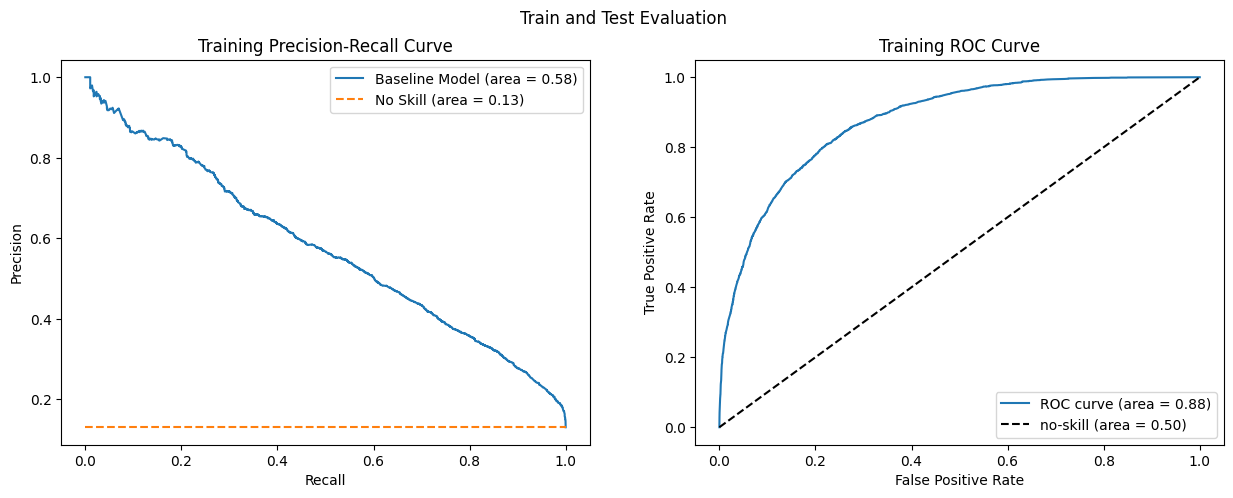

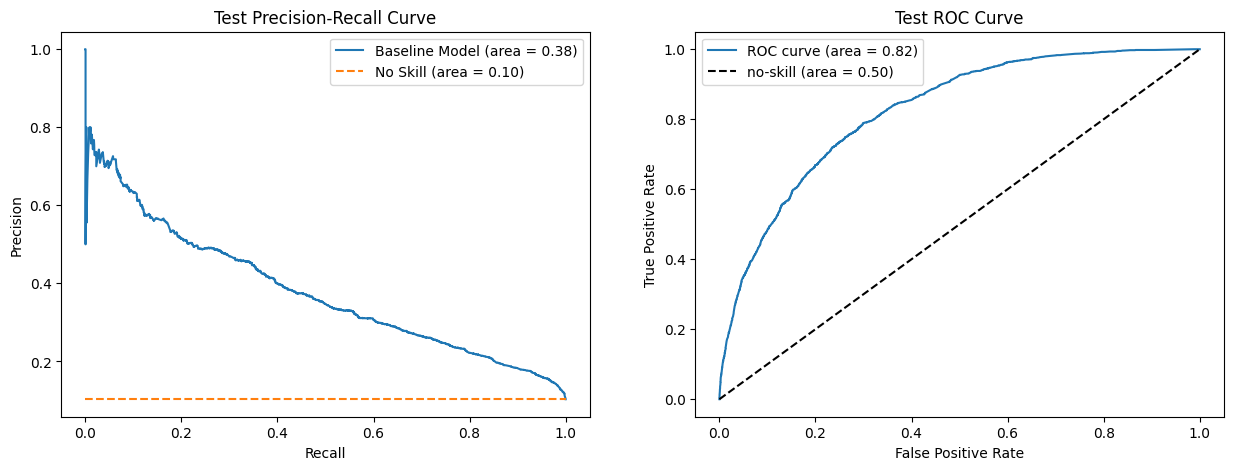

In [8]:
evaluate_model_with_train(train[target], test[target], train_preds[:, 1], test_preds[:, 1])

In [9]:
calculate_ks(train, 'TARGET_default_within_11m', 'preds1', 'preds0', 'train')
calculate_ks(test, 'TARGET_default_within_11m', 'preds1', 'preds0', 'test')
calculate_ks(valid, 'TARGET_default_within_11m', 'preds1', 'preds0', 'valid')

np.random.seed(1)
random_default = np.random.rand(train.shape[0])
random_df = pd.DataFrame({
    'preds1': random_default,
    'preds0': 1 - random_default,
    'TARGET_default_within_11m': np.random.choice([0, 1], len(random_default), p=[train['TARGET_default_within_11m'].mean(), 1-train['TARGET_default_within_11m'].mean()])
})

calculate_ks(random_df, 'TARGET_default_within_11m', 'preds1', 'preds0', 'random')


train KS: 0.8576 (p-value: 0.000e+00)
test KS: 0.9114 (p-value: 0.000e+00)
valid KS: 0.9068 (p-value: 0.000e+00)
random KS: 0.0111 (p-value: 8.482e-01)


In [10]:
def assign_decile(x, bins):
    for bin_ in bins:
        if bin_['min'] <= x <= bin_['max']:
            return bin_['decile']
    return 0


# constructing bins for the scorecard
train['decile'] = pd.qcut(train['preds1'], 10, labels=False)
train_binned = train.groupby('decile').agg({target: ['mean', 'sum'], 'preds1': ['min', 'max']}).reset_index()
train_binned.columns = ['decile', 'mean', 'defaults', 'min', 'max']

bins = train_binned[['decile', 'min', 'max']]
bins['max'] = (bins['min'] - 1e-6).shift(-1).fillna(1)
bins = bins.to_dict(orient='records')

def attribute_default_statistics(df, target, preds1_col, bins, identifier=''):
    df['decile'] = df['preds1'].apply(lambda x: assign_decile(x, bins))
    binned = df.groupby('decile').agg({target: ['mean', 'sum', 'count'], preds1_col: ['min', 'max']}).reset_index()
    binned.columns = ['decile', 'mean', 'defaults', 'customers', 'min', 'max']
    binned['data'] = identifier
    return binned

train_binned = attribute_default_statistics(train, target, 'preds1', bins, 'train')
test_binned = attribute_default_statistics(test, target, 'preds1', bins, 'test')
valid_binned = attribute_default_statistics(valid, target, 'preds1', bins, 'valid')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
bins_df = pd.DataFrame(bins)
bins_df

,decile,min,max
0,0,0.000000,0.005368
1,1,0.005369,0.017014
2,2,0.017015,0.024134
3,3,0.024135,0.047793
4,4,0.047794,0.066391
5,5,0.066392,0.091006
6,6,0.091007,0.143008
7,7,0.143009,0.213564
8,8,0.213565,0.371811
9,9,0.371812,1.000000


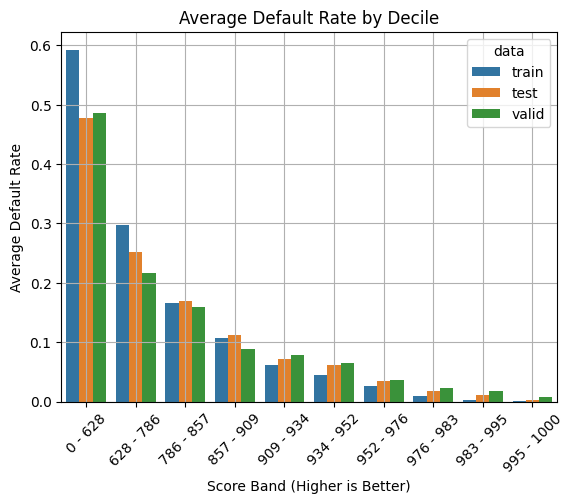

In [12]:
bins_average_default_rate = pd.concat([train_binned, test_binned, valid_binned])
plot_data = bins_average_default_rate.sort_values('decile', ascending=False)
plot_data['rev_decile'] = plot_data['decile'].apply(lambda x: 9 - x)

scores = [f"{1000*(1-j):.0f} - {1000*(1-i):.0f}" for (i, j) in zip(bins_df['min'], bins_df['max'])]
sns.barplot(x='rev_decile', y='mean', data=plot_data, hue='data', hue_order=['train', 'test', 'valid'])
plt.xticks(rotation=45, labels=scores[::-1], ticks=list(range(10)))
plt.title('Average Default Rate by Decile')
plt.xlabel('Score Band (Higher is Better)')
plt.ylabel('Average Default Rate')
plt.grid()
plt.show()


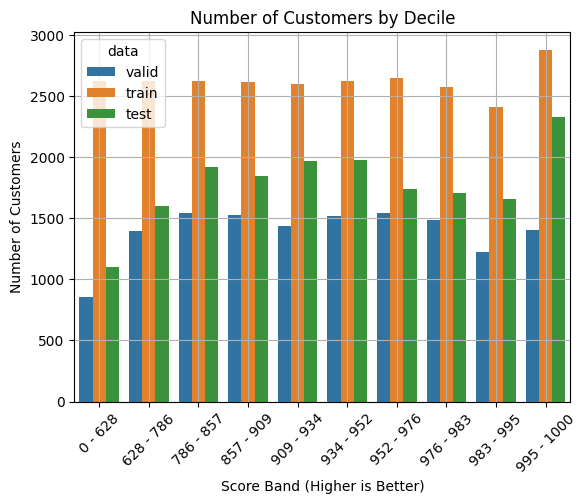

In [13]:
bins_average_default_rate = pd.concat([train_binned, test_binned, valid_binned])
plot_data = bins_average_default_rate.sort_values('decile', ascending=False)
plot_data['rev_decile'] = plot_data['decile'].apply(lambda x: 9 - x)

scores = [f"{1000*(1-j):.0f} - {1000*(1-i):.0f}" for (i, j) in zip(bins_df['min'], bins_df['max'])]
sns.barplot(x='rev_decile', y='customers', data=plot_data, hue='data')
plt.xticks(rotation=45, labels=scores[::-1], ticks=list(range(10)))
plt.title('Number of Customers by Decile')
plt.xlabel('Score Band (Higher is Better)')
plt.ylabel('Number of Customers')
plt.grid()
plt.show()


In [14]:
bins_average_default_rate.sort_values(['data', 'decile'], ascending=False)

,decile,mean,defaults,customers,min,max,data
9,9,0.485948,415,854,0.371942,0.950000,valid
8,8,0.216583,303,1399,0.213789,0.371223,valid
7,7,0.159326,246,1544,0.143009,0.213518,valid
6,6,0.088525,135,1525,0.091007,0.142930,valid
5,5,0.079332,114,1437,0.066392,0.090897,valid
4,4,0.064729,98,1514,0.047796,0.066348,valid
3,3,0.035645,55,1543,0.024135,0.047791,valid
2,2,0.022177,33,1488,0.017015,0.023880,valid
1,1,0.017185,21,1222,0.005369,0.016973,valid
0,0,0.007128,10,1403,0.000000,0.005341,valid


# Importances

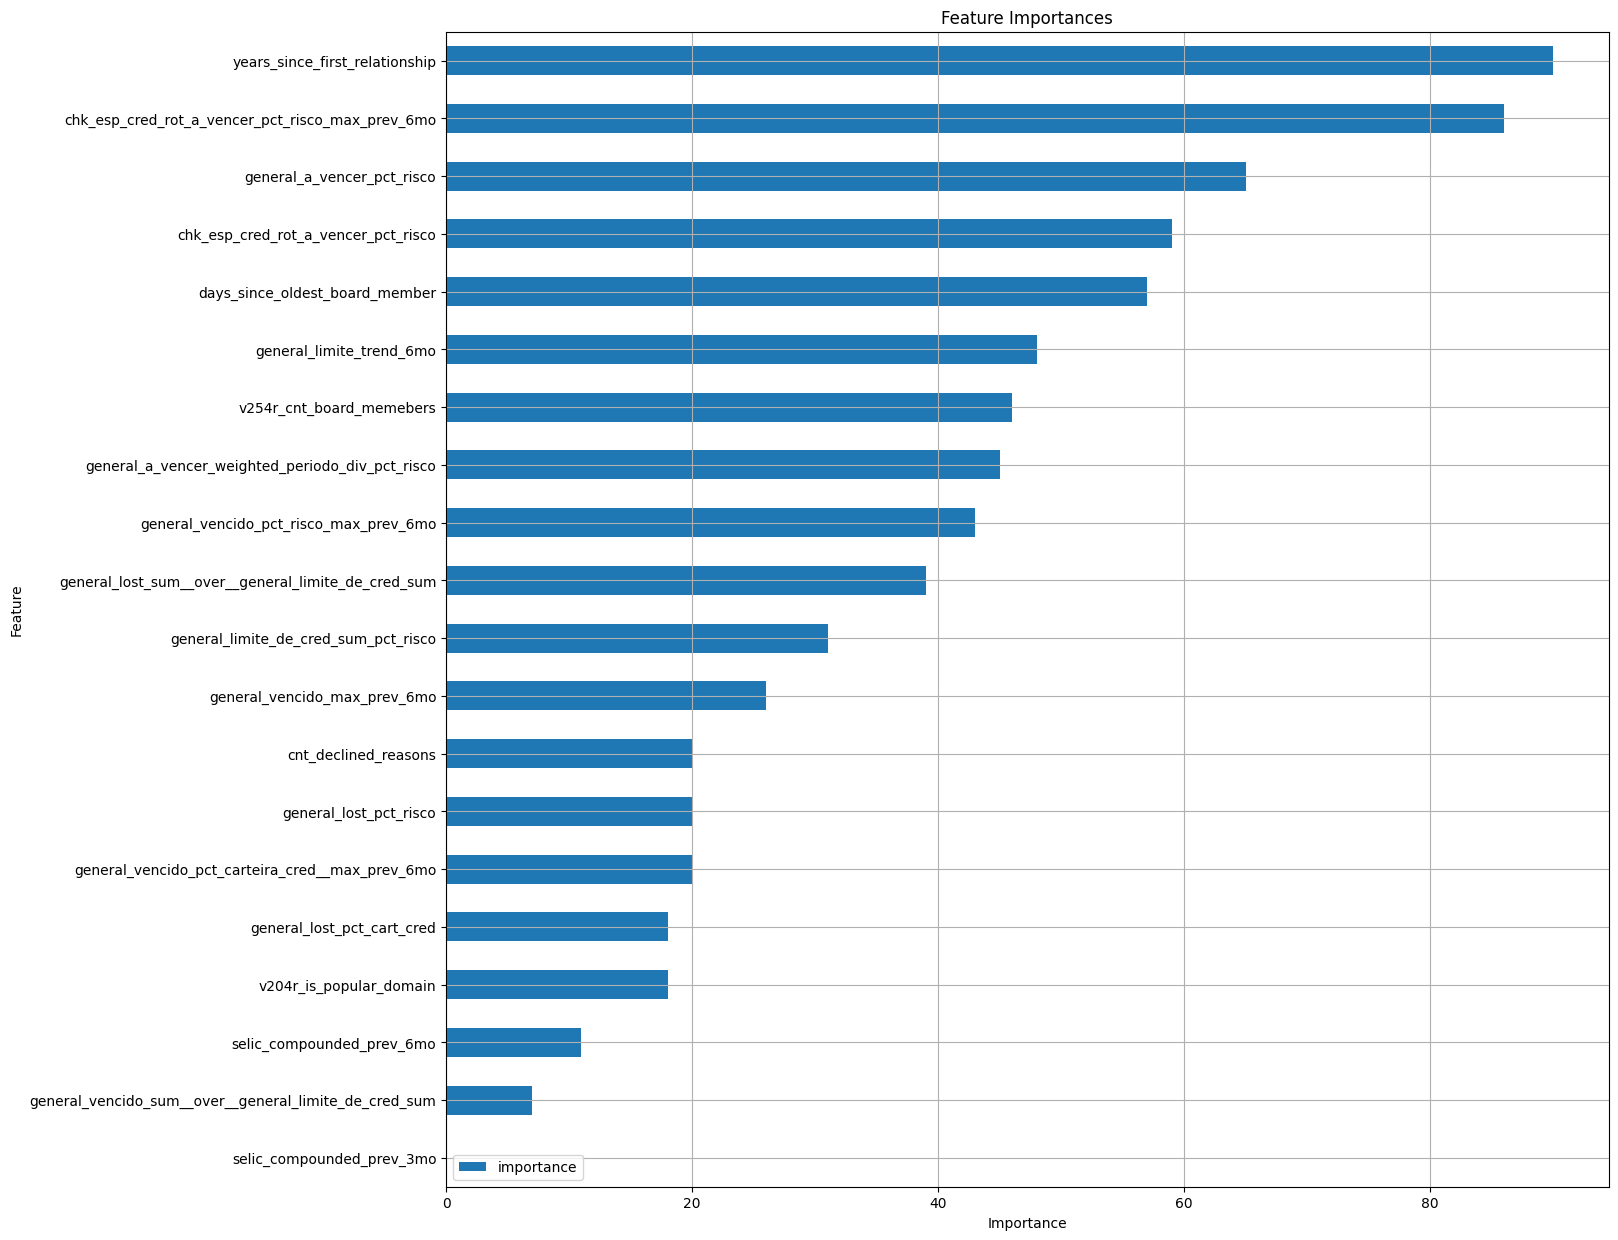

In [15]:
pd.DataFrame(model_pipeline['classifier'].calibrated_classifiers_[0].estimator.feature_importances_, index=model_input_features, columns=['importance']).sort_values('importance', ascending=True).plot(kind='barh', figsize=(15, 15))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid()
plt.show()

In [16]:
from sklearn.pipeline import Pipeline
train_model_input = Pipeline(model_pipeline.steps[:-1]).transform(train[features])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


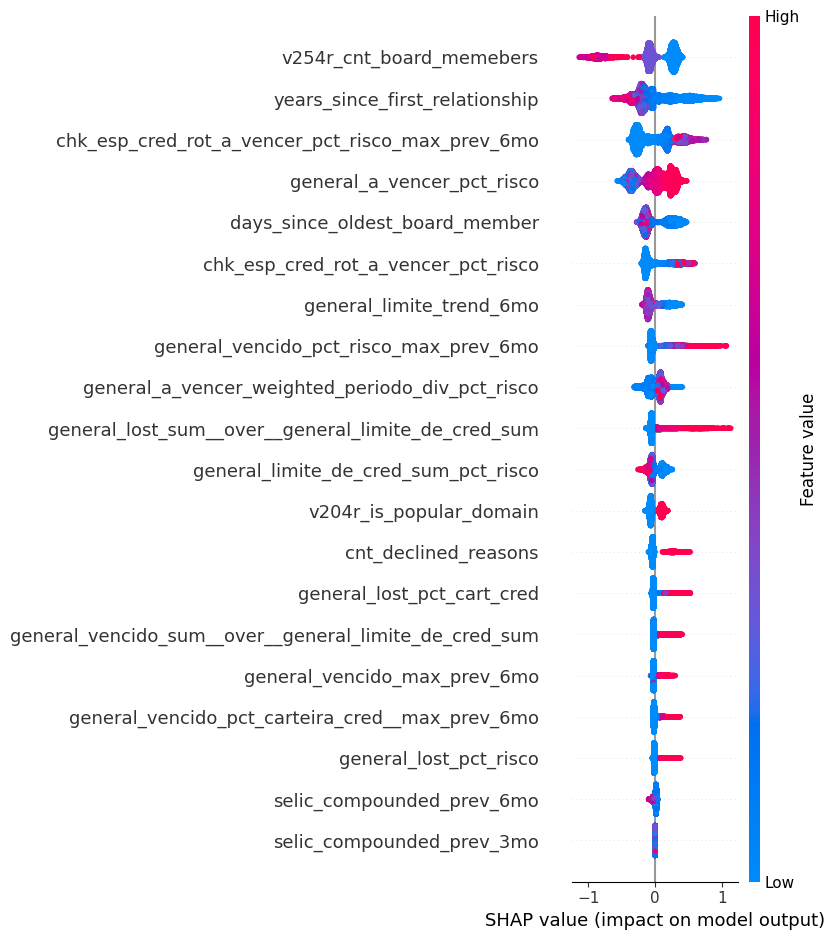

In [17]:
# interaction plots
expl_model = model_pipeline['classifier'].calibrated_classifiers_[0].estimator
explainer = shap.TreeExplainer(expl_model)
shap_values = explainer.shap_values(train_model_input)[1]


shap.summary_plot(shap_values, train_model_input, feature_names=model_input_features)

# Nice-to-have - LGPD / Model Explainability

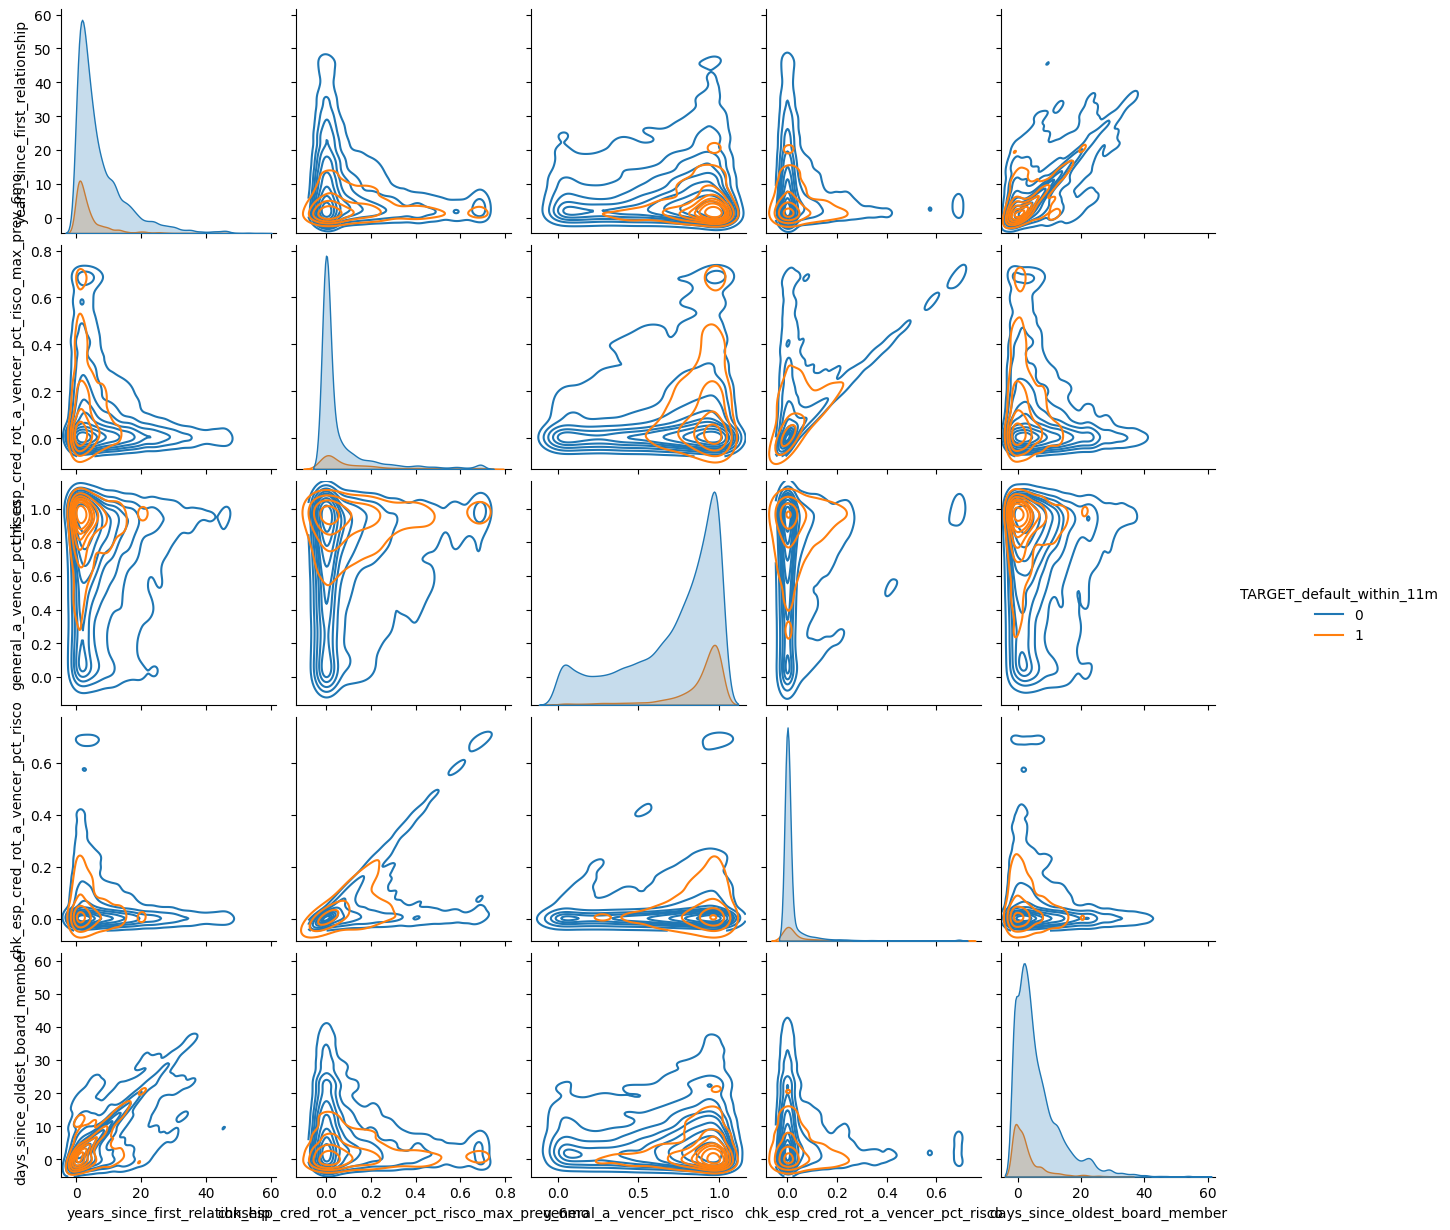

In [18]:
expl_sample = (
    pd.DataFrame(model_pipeline['classifier'].calibrated_classifiers_[0].estimator.feature_importances_,
                 index=model_input_features, columns=['importance']).sort_values('importance', ascending=False).index[:5]
                 )

sns.pairplot(train_model_input[expl_sample].join(train[target]), hue=target, kind='kde')
plt.xticks(rotation=45)
plt.show()

In [19]:
train[11:12]

,fake_cnpj,date_reference,general_lost_pct_risco,years_since_first_relationship,chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,days_since_oldest_board_member,v001r_social_capital,cnt_declined_reasons,chk_esp_cred_rot_a_vencer_pct_risco,general_limite_de_cred_sum_pct_risco,...,general_vencido_pct_carteira_cred__max_prev_6mo,TARGET_default_within_11m,year_month,valor,selic_compounded_prev_12mo,selic_compounded_prev_6mo,selic_compounded_prev_3mo,preds1,preds0,decile
11,508,2020-10-01,0.0,24.852055,0.205895,4.358904,0.0,0,0.004582,0.1905,...,0.0,0,2020-10-01,1.00157,0.035431,0.012507,0.005121,0.023041,0.976959,2


In [20]:
# force plot for a single observation: CNPJ 508
cnpj_index = 11
shap.force_plot(explainer.expected_value[1], shap_values[cnpj_index], train_model_input.iloc[cnpj_index], feature_names=model_input_features)

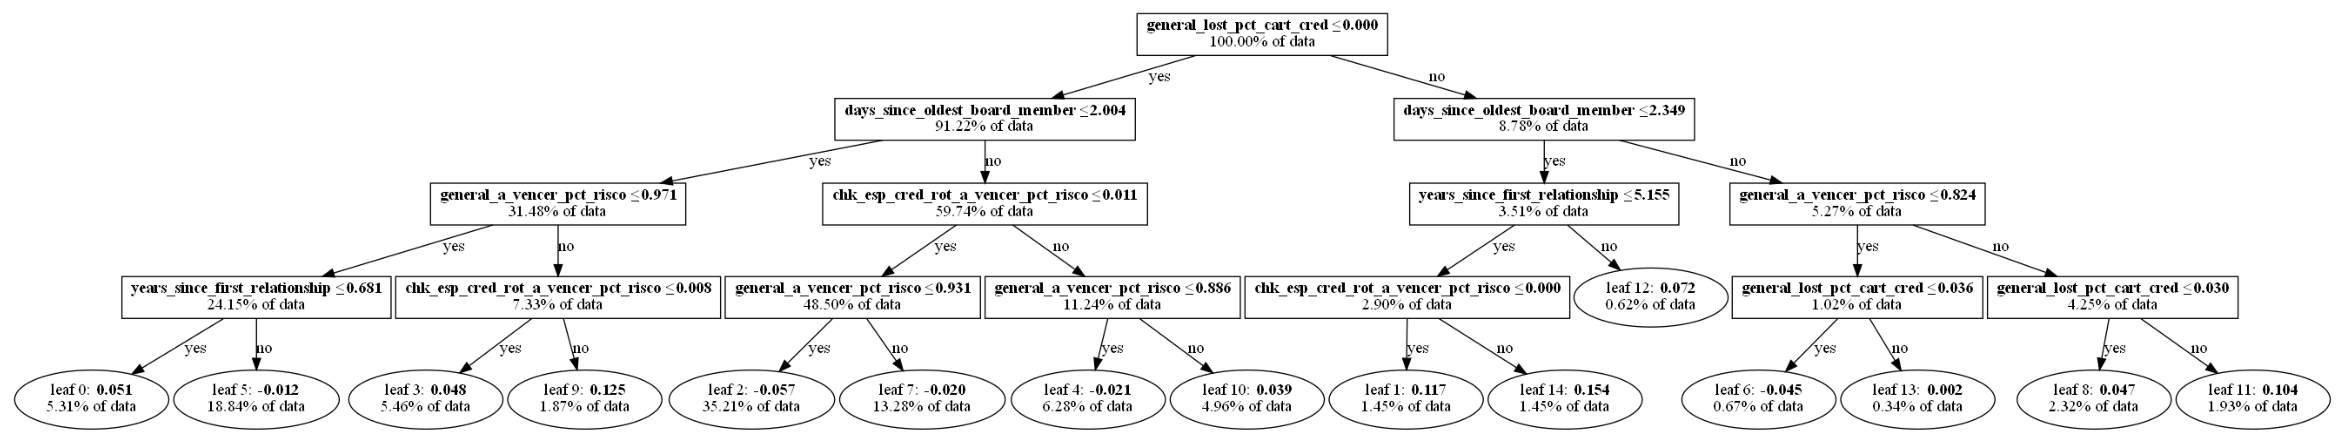

In [21]:
# single tree plot
import lightgbm as lgbm
lgbm.plot_tree(expl_model, tree_index=5, figsize=(30, 30), show_info=['data_percentage'], orientation='vertical')
plt.show()